In [255]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from category_encoders.target_encoder import TargetEncoder

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier ,RandomForestClassifier
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [256]:
data = pd.read_csv("applicant.csv")
loandata = pd.read_csv("loan.csv")

In [257]:
print(loandata['high_risk_applicant'].value_counts())

0    700
1    300
Name: high_risk_applicant, dtype: int64


Data is highly imbalanced 

In [258]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   applicant_id                                              1000 non-null   int64 
 1   Primary_applicant_age_in_years                            1000 non-null   int64 
 2   Gender                                                    1000 non-null   object
 3   Marital_status                                            1000 non-null   object
 4   Number_of_dependents                                      1000 non-null   int64 
 5   Housing                                                   1000 non-null   object
 6   Years_at_current_residence                                1000 non-null   int64 
 7   Employment_status                                         1000 non-null   object
 8   Has_been_employed_for_at_leas

In [259]:
loandata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   loan_application_id                          1000 non-null   object
 1   applicant_id                                 1000 non-null   int64 
 2   Months_loan_taken_for                        1000 non-null   int64 
 3   Purpose                                      988 non-null    object
 4   Principal_loan_amount                        1000 non-null   int64 
 5   EMI_rate_in_percentage_of_disposable_income  1000 non-null   int64 
 6   Property                                     846 non-null    object
 7   Has_coapplicant                              1000 non-null   int64 
 8   Has_guarantor                                1000 non-null   int64 
 9   Other_EMI_plans                              186 non-null    object
 10  Number_of_exi

### Data Cleaning

Dropping irrelevant columns

In [260]:
data_e1 = data.drop(['Telephone','Balance_in_existing_bank_account_(lower_limit_of_bucket)'],axis =1)
loandata_ = loandata.drop(['loan_application_id','Other_EMI_plans'],axis=1)

Renaming columns names

In [261]:
data_e1.rename(columns={'Has_been_employed_for_at_least':'employed_at_least_years','Has_been_employed_for_at_most':'employed_at_most_years','Balance_in_existing_bank_account_(upper_limit_of_bucket)':'bank_balance_upper_limit'},inplace=True)

Converting irrelevant string values into numbers

In [262]:
data_e1["employed_at_least_years"]=data_e1["employed_at_least_years"][data_e1["employed_at_least_years"].isnull()!=True].apply(lambda x:int(re.sub("\D","",x)))
data_e1["employed_at_most_years"]=data_e1["employed_at_most_years"][data_e1["employed_at_most_years"].isnull()!=True].apply(lambda x:int(re.sub("\D","",x)))
data_e1["bank_balance_upper_limit"]=data_e1["bank_balance_upper_limit"][data_e1["bank_balance_upper_limit"].isnull()!=True].apply(lambda x:int(re.sub("\D","",x)))

In [263]:
data_e1

,applicant_id,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,employed_at_least_years,employed_at_most_years,Foreign_worker,Savings_account_balance,bank_balance_upper_limit
0,1469590,67,male,single,1,own,4,skilled employee / official,7.0,NaN,1,NaN,0.0
1,1203873,22,female,divorced/separated/married,1,own,2,skilled employee / official,1.0,4.0,1,Low,2.0
2,1432761,49,male,single,2,own,3,unskilled - resident,4.0,7.0,1,Low,NaN
3,1207582,45,male,single,2,for free,4,skilled employee / official,4.0,7.0,1,Low,0.0
4,1674436,53,male,single,2,for free,4,skilled employee / official,1.0,4.0,1,Low,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1880194,31,female,divorced/separated/married,1,own,4,unskilled - resident,4.0,7.0,1,Low,NaN
996,1114064,40,male,divorced/separated,1,own,4,management / self-employed / highly qualified ...,1.0,4.0,1,Low,0.0
997,1758046,38,male,single,1,own,4,skilled employee / official,7.0,NaN,1,Low,NaN
998,1824545,23,male,single,1,for free,4,skilled employee / official,1.0,4.0,1,Low,0.0


### Data imputation

Imputing Nan values using Median imputation

In [264]:
# filling Nan values by groupby median
data_e1["employed_at_least_years"].fillna(data_e1.groupby('Employment_status')['employed_at_least_years'].transform('median'),inplace=True)
data_e1["bank_balance_upper_limit"].fillna(data_e1.groupby('Employment_status')['bank_balance_upper_limit'].transform('median'),inplace=True)

# Employement at most years have dependency on Employment status as well as on  employed_at_least_years
data_e1["employed_at_most_years"].fillna(data_e1.groupby(['Employment_status','employed_at_least_years'])['employed_at_most_years'].transform('median'),inplace=True)


In [265]:
# Ordinal encoding of Savings_account_balance
# Median imputation of Nan values dpending upon employment status
data_e1['Savings_account_balance'] = data_e1['Savings_account_balance'].replace(['Low','Medium','High','Very high'],[1,2,3,4])

data_e1["Savings_account_balance"].fillna(data_e1.groupby('Employment_status')['Savings_account_balance'].transform('median'),inplace=True)


In [266]:
## filling Nan values using forward fill
loandata['Property'].fillna(method = 'ffill',limit =1,inplace=True)
loandata['Purpose'].fillna(method ='ffill',limit =1,inplace=True)

In [267]:
# checking for nan values if remaining any
data_e1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   applicant_id                    1000 non-null   int64  
 1   Primary_applicant_age_in_years  1000 non-null   int64  
 2   Gender                          1000 non-null   object 
 3   Marital_status                  1000 non-null   object 
 4   Number_of_dependents            1000 non-null   int64  
 5   Housing                         1000 non-null   object 
 6   Years_at_current_residence      1000 non-null   int64  
 7   Employment_status               1000 non-null   object 
 8   employed_at_least_years         1000 non-null   float64
 9   employed_at_most_years          747 non-null    float64
 10  Foreign_worker                  1000 non-null   int64  
 11  Savings_account_balance         1000 non-null   float64
 12  bank_balance_upper_limit        100

In [268]:
# Imputing employed_at_most_years Nan values depending upon employed_at_least_years which relevant 

print(data_e1['employed_at_least_years'][data_e1['employed_at_most_years'].isnull()==True].max())
print(data_e1['employed_at_least_years'][data_e1['employed_at_most_years'].isnull()==True].min())

#data_e1['employed_at_most_years'][data_e1['employed_at_most_years'].isnull()==True]=7

7.0
7.0


In [269]:
data_e1['employed_at_most_years'].fillna(7,inplace=True)

#### Data after imputation

In [270]:
data_e1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   applicant_id                    1000 non-null   int64  
 1   Primary_applicant_age_in_years  1000 non-null   int64  
 2   Gender                          1000 non-null   object 
 3   Marital_status                  1000 non-null   object 
 4   Number_of_dependents            1000 non-null   int64  
 5   Housing                         1000 non-null   object 
 6   Years_at_current_residence      1000 non-null   int64  
 7   Employment_status               1000 non-null   object 
 8   employed_at_least_years         1000 non-null   float64
 9   employed_at_most_years          1000 non-null   float64
 10  Foreign_worker                  1000 non-null   int64  
 11  Savings_account_balance         1000 non-null   float64
 12  bank_balance_upper_limit        100

In [271]:
data_e1[0:5]

,applicant_id,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,employed_at_least_years,employed_at_most_years,Foreign_worker,Savings_account_balance,bank_balance_upper_limit
0,1469590,67,male,single,1,own,4,skilled employee / official,7.0,7.0,1,1.0,0.0
1,1203873,22,female,divorced/separated/married,1,own,2,skilled employee / official,1.0,4.0,1,1.0,2.0
2,1432761,49,male,single,2,own,3,unskilled - resident,4.0,7.0,1,1.0,0.0
3,1207582,45,male,single,2,for free,4,skilled employee / official,4.0,7.0,1,1.0,0.0
4,1674436,53,male,single,2,for free,4,skilled employee / official,1.0,4.0,1,1.0,0.0


In [272]:
data_e1.corr()

,applicant_id,Primary_applicant_age_in_years,Number_of_dependents,Years_at_current_residence,employed_at_least_years,employed_at_most_years,Foreign_worker,Savings_account_balance,bank_balance_upper_limit
applicant_id,1.000000,-0.010583,0.017048,-0.028017,0.016720,0.004312,0.066389,0.019670,0.008323
Primary_applicant_age_in_years,-0.010583,1.000000,0.118201,0.266419,0.356529,0.205770,0.006151,0.015772,-0.029560
Number_of_dependents,0.017048,0.118201,1.000000,0.042643,0.088243,0.091470,-0.077071,-0.009664,-0.067391
Years_at_current_residence,-0.028017,0.266419,0.042643,1.000000,0.301341,0.206418,0.054097,0.024568,-0.069810
employed_at_least_years,0.016720,0.356529,0.088243,0.301341,1.000000,0.789677,0.058977,0.025327,-0.015105
employed_at_most_years,0.004312,0.205770,0.091470,0.206418,0.789677,1.000000,0.021698,0.065389,-0.104441
Foreign_worker,0.066389,0.006151,-0.077071,0.054097,0.058977,0.021698,1.000000,-0.007892,0.062034
Savings_account_balance,0.019670,0.015772,-0.009664,0.024568,0.025327,0.065389,-0.007892,1.000000,0.027697
bank_balance_upper_limit,0.008323,-0.029560,-0.067391,-0.069810,-0.015105,-0.104441,0.062034,0.027697,1.000000


Here we can easily conclude with correlation heatmap that data is not correlated.
only the features employed_at_least_years and employed_at_most_years are correlated so we can drop one of them.

In [273]:
data_e1= data_e1.drop('employed_at_least_years',axis=1)

In [274]:
loandata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   loan_application_id                          1000 non-null   object
 1   applicant_id                                 1000 non-null   int64 
 2   Months_loan_taken_for                        1000 non-null   int64 
 3   Purpose                                      1000 non-null   object
 4   Principal_loan_amount                        1000 non-null   int64 
 5   EMI_rate_in_percentage_of_disposable_income  1000 non-null   int64 
 6   Property                                     978 non-null    object
 7   Has_coapplicant                              1000 non-null   int64 
 8   Has_guarantor                                1000 non-null   int64 
 9   Other_EMI_plans                              186 non-null    object
 10  Number_of_exi

Here we can see correlation between Months_loan_taken_for and Principal_loan_amount so it increases collinearity

In [275]:
data_final = pd.merge(data_e1,loandata,on='applicant_id')

In [276]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   applicant_id                                 1000 non-null   int64  
 1   Primary_applicant_age_in_years               1000 non-null   int64  
 2   Gender                                       1000 non-null   object 
 3   Marital_status                               1000 non-null   object 
 4   Number_of_dependents                         1000 non-null   int64  
 5   Housing                                      1000 non-null   object 
 6   Years_at_current_residence                   1000 non-null   int64  
 7   Employment_status                            1000 non-null   object 
 8   employed_at_most_years                       1000 non-null   float64
 9   Foreign_worker                               1000 non-null   int64  
 10  S

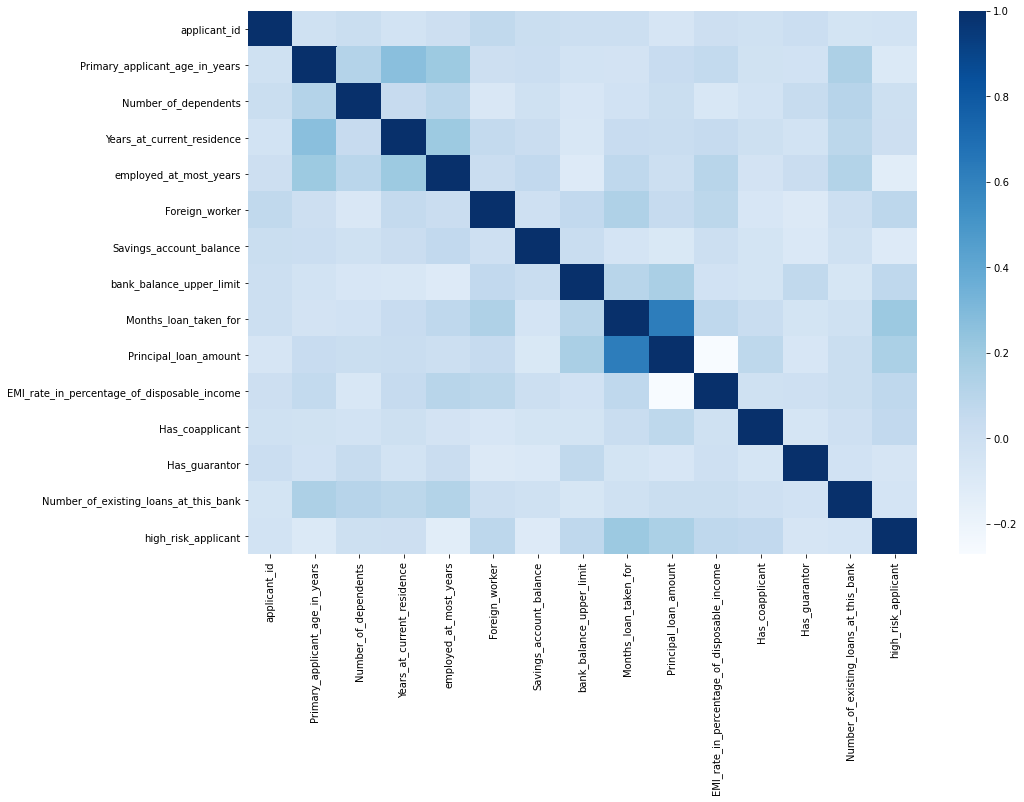

In [277]:
sns.heatmap(data_final.corr(),cmap='Blues')
plt.gcf().set_size_inches(15, 10)


### Imputing Categorical Features

In [278]:
categorical_feature = data_final.select_dtypes(include='object').columns

In [279]:
def target_encoder(data):
    for col in data.select_dtypes(include='object').columns:
        te=TargetEncoder()
        data[col]=te.fit_transform(data[col],data.high_risk_applicant)
    return data


In [280]:
data_final_encoded = target_encoder(data_final)

C:\Users\cnctk\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\cnctk\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\cnctk\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\cnctk\anaconda3\lib\site-packages\category_encoders\target_enco

### Minmax scaling

In [281]:
def scaler_fnc(data):
        for col in data.select_dtypes(exclude='object').columns:
            minscaler = MinMaxScaler()
            data[col]= minscaler.fit_transform(data[[col]])
        return data

In [282]:
data_encoded_scaled = scaler_fnc(data_final_encoded)

## train test data split

In [283]:
train,test= train_test_split( data_encoded_scaled,test_size=0.2, random_state=202)

In [284]:
train.high_risk_applicant.value_counts()

0.0    550
1.0    250
Name: high_risk_applicant, dtype: int64

#### Upsampling Imbalance data

In [285]:
### Data balacing by upsampling

from sklearn.utils import resample

train_majority = train[train.high_risk_applicant==0]
train_minority = train[train.high_risk_applicant==1]
 
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=550,    # to match majority class
                                 random_state=425) # reproducible results
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

train_upsampled.high_risk_applicant.value_counts()

0.0    550
1.0    550
Name: high_risk_applicant, dtype: int64

In [286]:
train_x = train_upsampled.drop('high_risk_applicant',axis=1)
train_y = train_upsampled['high_risk_applicant']

test_x= test.drop('high_risk_applicant',axis=1)
test_y = test['high_risk_applicant']

## XGBoost classifier

best parameter {'learning_rate': 0.015, 'max_depth': 5, 'n_estimators': 700}
train accurcay 0.9827272727272728 
test accuracy 0.6


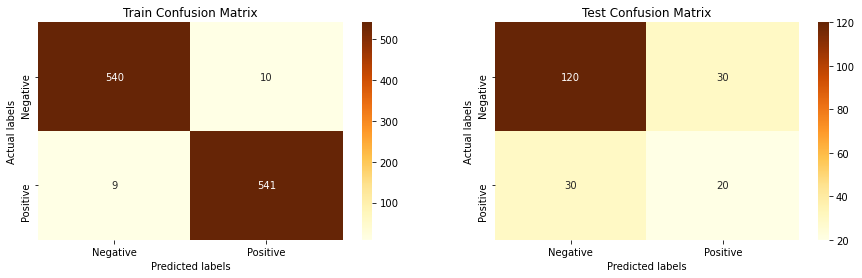

precision: 0.4 
recall: 0.4
precision: 0.9818511796733213 
recall: 0.9836363636363636


In [287]:

classifier_xgb = XGBClassifier()
param_grid = {"max_depth":[2,3,4, 5],"n_estimators": [200,300,500, 600, 700],"learning_rate": [0.0001,0.01, 0.015]}
clf_xgb = GridSearchCV(classifier_xgb, param_grid, cv=5)
clf_xgb.fit(train_x, train_y)
print("best parameter",clf_xgb.best_params_)

classifier_xgb=XGBClassifier(learning_rate = clf_xgb.best_params_["learning_rate"],
                           n_estimators  = clf_xgb.best_params_["n_estimators"],
                           max_depth     = clf_xgb.best_params_["max_depth"])
classifier_xgb.fit(train_x, train_y)

y_pred_train= classifier_xgb.predict(train_x)
y_pred_test  =classifier_xgb.predict(test_x)
train_auc = roc_auc_score(train_y,y_pred_train)
test_auc = roc_auc_score(test_y,y_pred_test)
print("train accurcay",train_auc,"\ntest accuracy",test_auc)

# confusion matrix
train_cm = confusion_matrix(train_y, y_pred_train)
test_cm = confusion_matrix(test_y, y_pred_test)
# Create a DataFrame from the confusion matrix
#cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

fig ,ax= plt.subplots(1,2,figsize =(15,4))

sns.heatmap(train_cm, fmt='d',annot=True,cmap='YlOrBr',ax=ax[0])
ax[0].set_xlabel('Predicted labels') # labels, title and ticks
ax[0].set_ylabel('Actual labels')
ax[0].set_ylim(2.0, 0)
ax[0].set_title('Train Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Negative','Positive']) 
ax[0].yaxis.set_ticklabels(['Negative','Positive'])


sns.heatmap(test_cm, fmt = 'd',annot=True,cmap='YlOrBr',ax=ax[1])
ax[1].set_xlabel('Predicted labels') # labels, title and ticks 
ax[1].set_ylabel('Actual labels')
ax[1].set_ylim(2.0, 0)
ax[1].set_title('Test Confusion Matrix')
ax[1].xaxis.set_ticklabels(['Negative','Positive']) 
ax[1].yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

precision = test_cm[1][1]/(test_cm[1][1]+test_cm[0][1])
recall =   test_cm[1][1]/(test_cm[1][1]+test_cm[1][0])
print("precision:",precision,"\nrecall:",recall)

precision = train_cm[1][1]/(train_cm[1][1]+train_cm[0][1])
recall =   train_cm[1][1]/(train_cm[1][1]+train_cm[1][0])
print("precision:",precision,"\nrecall:",recall)

## SVM classifier

best parameter {'C': 0.1, 'kernel': 'linear'}


train accurcay 0.7263636363636364 
test accuracy 0.6366666666666667


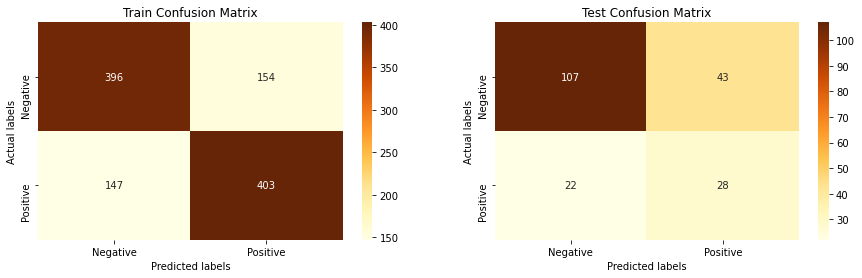



for train data
precision: 0.7235188509874326 
recall: 0.7327272727272728


for test data
precision: 0.39436619718309857 
recall: 0.56


In [288]:
classifier_svc= SVC()
param_grid = {"C":[0.001,0.03,0.10, 1,10,15,20,30,50,100],"kernel":['linear']}
clf_svc = GridSearchCV(classifier_svc, param_grid, cv=5)
clf_svc.fit(train_x, train_y)
print("best parameter",clf_svc.best_params_)
classifier_svc=SVC(C = clf_svc.best_params_["C"],
                           kernel  = clf_svc.best_params_["kernel"])
classifier_svc.fit(train_x, train_y)
y_pred_train= classifier_svc.predict(train_x)
y_pred_test  =classifier_svc.predict(test_x)
train_auc = roc_auc_score(train_y,y_pred_train)
test_auc = roc_auc_score(test_y,y_pred_test)
print("\n\ntrain accurcay",train_auc,"\ntest accuracy",test_auc)

# confusion matrix
train_cm = confusion_matrix(train_y, y_pred_train)
test_cm = confusion_matrix(test_y, y_pred_test)

fig ,ax= plt.subplots(1,2,figsize =(15,4))
sns.heatmap(train_cm, fmt='d',annot=True,cmap='YlOrBr',ax=ax[0])
ax[0].set_xlabel('Predicted labels') # labels, title and ticks
ax[0].set_ylabel('Actual labels')
ax[0].set_ylim(2.0, 0)
ax[0].set_title('Train Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Negative','Positive']) 
ax[0].yaxis.set_ticklabels(['Negative','Positive'])

sns.heatmap(test_cm, fmt = 'd',annot=True,cmap='YlOrBr',ax=ax[1])
ax[1].set_xlabel('Predicted labels') # labels, title and ticks 
ax[1].set_ylabel('Actual labels')
ax[1].set_ylim(2.0, 0)
ax[1].set_title('Test Confusion Matrix')
ax[1].xaxis.set_ticklabels(['Negative','Positive']) 
ax[1].yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

print("\n\nfor train data")
precision = train_cm[1][1]/(train_cm[1][1]+train_cm[0][1])
recall =   train_cm[1][1]/(train_cm[1][1]+train_cm[1][0])
print("precision:",precision,"\nrecall:",recall)


print("\n\nfor test data")
precision = test_cm[1][1]/(test_cm[1][1]+test_cm[0][1])
recall =   test_cm[1][1]/(test_cm[1][1]+test_cm[1][0])
print("precision:",precision,"\nrecall:",recall)

## Adaboost model

best parameter {'learning_rate': 0.01, 'n_estimators': 600}



train accurcay 0.9827272727272728 
test accuracy 0.6


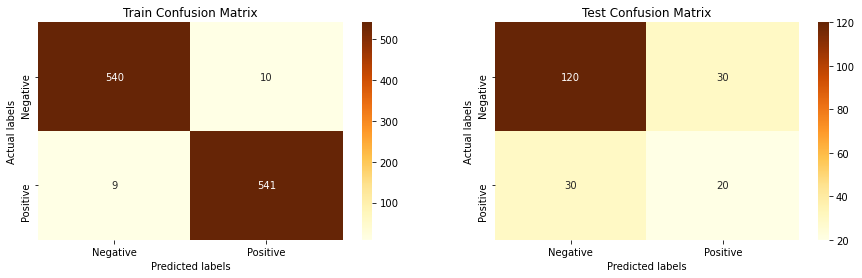



for train data
precision: 0.9818511796733213 
recall: 0.9836363636363636


for test data
precision: 0.4 
recall: 0.4


In [289]:
classifier_adbost = AdaBoostClassifier()
param_grid = {"n_estimators": [200,300,500, 600, 700],"learning_rate": [0.0001,0.01, 0.015]}
clf_adbost = GridSearchCV(classifier_adbost, param_grid, cv=5)
clf_adbost.fit(train_x, train_y)

print("best parameter",clf_adbost.best_params_)

classifier_adbost=AdaBoostClassifier(learning_rate = clf_adbost.best_params_["learning_rate"],
                           n_estimators  = clf_adbost.best_params_["n_estimators"]
                           )
classifier_adbost.fit(train_x, train_y)

y_pred_train= classifier_xgb.predict(train_x)
y_pred_test  =classifier_xgb.predict(test_x)
train_auc = roc_auc_score(train_y,y_pred_train)
test_auc = roc_auc_score(test_y,y_pred_test)
print("\n\n\ntrain accurcay",train_auc,"\ntest accuracy",test_auc)

# confusion matrix
train_cm = confusion_matrix(train_y, y_pred_train)
test_cm = confusion_matrix(test_y, y_pred_test)
# Create a DataFrame from the confusion matrix
#cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

fig ,ax= plt.subplots(1,2,figsize =(15,4))

sns.heatmap(train_cm, fmt='d',annot=True,cmap='YlOrBr',ax=ax[0])
ax[0].set_xlabel('Predicted labels') # labels, title and ticks
ax[0].set_ylabel('Actual labels')
ax[0].set_ylim(2.0, 0)
ax[0].set_title('Train Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Negative','Positive']) 
ax[0].yaxis.set_ticklabels(['Negative','Positive'])


sns.heatmap(test_cm, fmt = 'd',annot=True,cmap='YlOrBr',ax=ax[1])
ax[1].set_xlabel('Predicted labels') # labels, title and ticks 
ax[1].set_ylabel('Actual labels')
ax[1].set_ylim(2.0, 0)
ax[1].set_title('Test Confusion Matrix')
ax[1].xaxis.set_ticklabels(['Negative','Positive']) 
ax[1].yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

print("\n\nfor train data")
precision = train_cm[1][1]/(train_cm[1][1]+train_cm[0][1])
recall =   train_cm[1][1]/(train_cm[1][1]+train_cm[1][0])
print("precision:",precision,"\nrecall:",recall)


print("\n\nfor test data")
precision = test_cm[1][1]/(test_cm[1][1]+test_cm[0][1])
recall =   test_cm[1][1]/(test_cm[1][1]+test_cm[1][0])
print("precision:",precision,"\nrecall:",recall)